In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB')

# Create a config of Lite model (16 filters), 15 joints, 2D joint coordinates, 21 classes
# with this config, the model summary should  be
# Total params: 149,557
# Trainable params: 147,765
# Non-trainable params: 1,792
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=64)

# Helper functions

In [4]:
def data_generator(T, C, le):
    X = T['pose'] # list of arrays
    Y = np.zeros(shape=(len(T['label']), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(T['label'])] = 1
    return X, Y

In [5]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

# Building the model

In [6]:
DD_Net = ddnet.create_DDNet(C)
DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1714816     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_ma

# Train, Test and Save/Load the Model

In [7]:
Train = pickle.load(open(os.path.join(data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

X_0, X_1 = ddnet.preprocess_batch(X, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test, C)

print(len(X), X_0.shape, X_1.shape, Y.shape)
print(len(X_test), X_test_0.shape, X_test_1.shape, Y.shape)

660 (660, 32, 105) (660, 32, 15, 2) (660, 21)
268 (268, 32, 105) (268, 32, 15, 2) (660, 21)


### Train and plot loss/accuracy

In [ ]:
import keras
from keras.optimizers import *

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


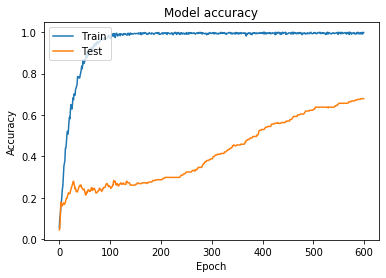

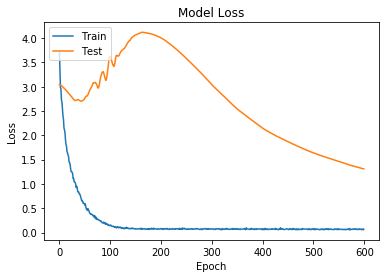

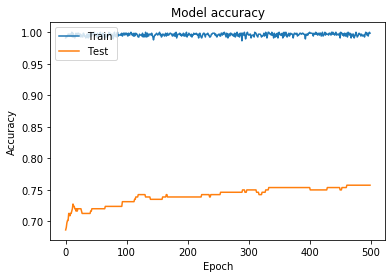

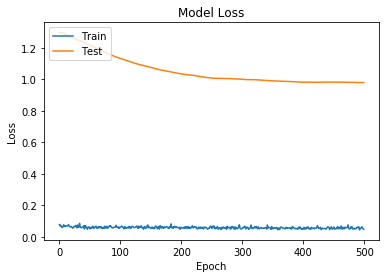

In [9]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [16]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

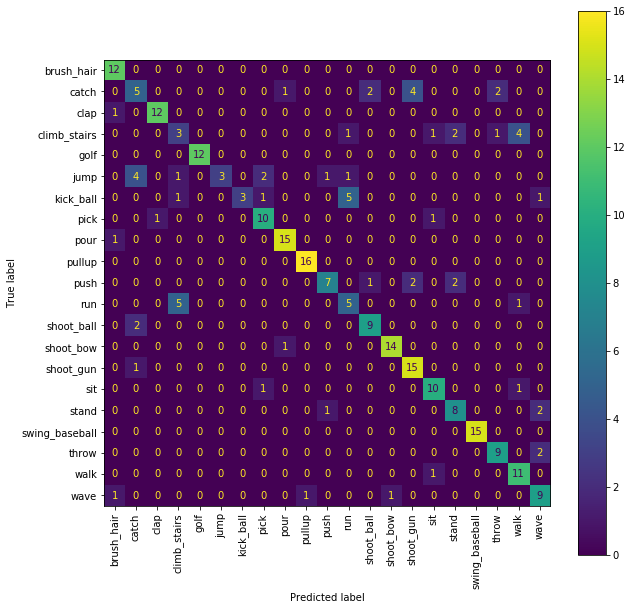

In [67]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
# print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save/Load Model

In [10]:
model_path = 'jhmdb_lite_model.h5'
ddnet.save_DDNet(DD_Net, model_path)

In [11]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)

268/268 [==============================] - 1s 3ms/step


[0.980810619112271, 0.7574626803398132]